In [89]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [90]:
spark = SparkSession.builder\
.master("local[*]")\
.appName("ML Stroke")\
.getOrCreate()
sc = spark.sparkContext

In [91]:
df = spark.read.csv('/home/hadoop/Downloads/stroke_clean.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [92]:
import pandas as pd
pd.DataFrame(df.take(5), columns = df.columns)

22/04/25 05:20:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke
 Schema: _c0, id, gender, age, hypertension, heart_disease, ever_married, work_type, Residence_type, avg_glucose_level, bmi, smoking_status, stroke
Expected: _c0 but found: 
CSV file: file:///home/hadoop/Downloads/stroke_clean.csv


,_c0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,2,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,3,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,4,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,5,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [93]:
df = df.select('gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
'smoking_status', 'stroke')

cols = df.columns

In [94]:
df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [95]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [96]:
categoricalColumns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [97]:
stages = []

In [98]:
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages = stages + [stringIndexer, encoder]

In [99]:
label_stringIdx = StringIndexer(inputCol = 'stroke', outputCol = 'label')
stages = stages + [label_stringIdx]

In [100]:
numericCols = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol = "features")
stages = stages + [assembler]

In [101]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)

df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)



In [102]:
pd.DataFrame(df.take(5), columns = df.columns)

,label,features
0,1.0,"(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."
1,1.0,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,1.0,"(0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,1.0,"(1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
4,1.0,"(1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


In [103]:
train, test = df.randomSplit([0.7, 0.3], seed = 2022)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3540
Test Dataset Count: 1570


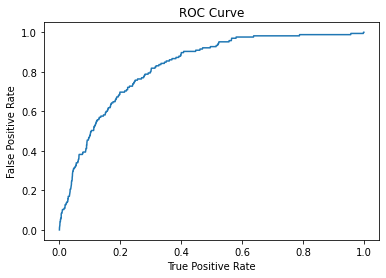

Training set Area Under ROC: 0.8267367003366941


In [105]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

trainingSummary = lrModel.summary

import matplotlib.pyplot as plt

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set Area Under ROC: ' + str(trainingSummary.areaUnderROC))

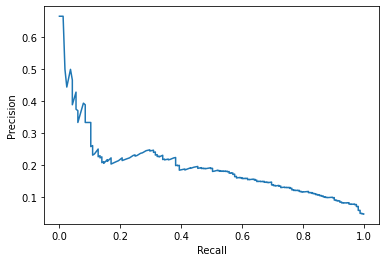

In [106]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [107]:
predictions = lrModel.transform(test)
predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)

+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  0.0|       0.0|[6.03360070865681...|[0.99760888307332...|
|  0.0|       0.0|[5.17246481057448...|[0.99436139941832...|
|  0.0|       0.0|[5.23782280591175...|[0.99471625713847...|
|  0.0|       0.0|[6.7698309090289,...|[0.99885342740564...|
|  0.0|       0.0|[4.97259096350297...|[0.99312244643284...|
|  0.0|       0.0|[5.00352503884499...|[0.99333054302912...|
|  0.0|       0.0|[5.40086385121379...|[0.99550759183144...|
|  0.0|       0.0|[6.17506892485930...|[0.99792365766450...|
|  0.0|       0.0|[4.60957088051948...|[0.99014205682358...|
|  0.0|       0.0|[4.67759485373870...|[0.99078435983713...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows



In [108]:
predictions.groupBy('label', 'prediction').count().show()

TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()

accuracy = (TN + TP) / (TN + TP + FN + FP)
#precision = TP / (TP + FP)
recall = TP / (TP + FN)
#F = 2 * (precision*recall) / (precision + recall)
#print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
#print('n F1 score: %0.3f' % F)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|   84|
|  0.0|       0.0| 1486|
+-----+----------+-----+

n recall: 0.000
n accuracy: 0.946


In [109]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('label', 'prediction', 'rawPrediction', 'probability').show(10)

+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  0.0|       0.0|[19.2761923077749...|[0.96380961538874...|
|  0.0|       0.0|[19.38672124236,0...|[0.969336062118,0...|
|  0.0|       0.0|[19.2761923077749...|[0.96380961538874...|
|  0.0|       0.0|[19.2761923077749...|[0.96380961538874...|
|  0.0|       0.0|[19.38672124236,0...|[0.969336062118,0...|
|  0.0|       0.0|[19.38672124236,0...|[0.969336062118,0...|
|  0.0|       0.0|[19.2761923077749...|[0.96380961538874...|
|  0.0|       0.0|[19.2761923077749...|[0.96380961538874...|
|  0.0|       0.0|[19.38672124236,0...|[0.969336062118,0...|
|  0.0|       0.0|[19.38672124236,0...|[0.969336062118,0...|
+-----+----------+--------------------+--------------------+
only showing top 10 rows



In [110]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8073407357559443


In [111]:
predictions.groupBy('label', 'prediction').count().show()

TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label <> prediction').count()
FP = predictions.filter('prediction = 1 AND label <> prediction').count()

accuracy = (TN + TP) / (TN + TP + FN + FP)
#precision = TP / (TP + FP)
recall = TP / (TP + FN)
#F = 2 * (precision*recall) / (precision + recall)
#print('n precision: %0.3f' % precision)
print('n recall: %0.3f' % recall)
print('n accuracy: %0.3f' % accuracy)
#print('n F1 score: %0.3f' % F)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       0.0|   84|
|  0.0|       0.0| 1486|
+-----+----------+-----+

n recall: 0.000
n accuracy: 0.946


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
